# Homework 3: Text classification with Maximum Entropy model

Can we detect sarcasm in news article headlines?

In this homework, we will formulate a Maximum Entropy (MaxEnt) models to classify news headlines into sarcastic or not sarcastic.

## Bibliography

1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019). https://arxiv.org/pdf/1908.07414.pdf
2. McCallum, Andrew, and Kamal Nigam. "A comparison of event models for naive bayes text classification." AAAI-98 workshop on learning for text categorization. Vol. 752. No. 1. 1998. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf
3. Kaggle dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

## News article headlines dataset

We will use the "Sarcasm headlines" dataset, collected by Ref. (1), and downloaded from Kaggle (3). The dataset consists of a series of headlines from news articles, classified as either being sarcastic, or not. The authors of (1) collected news from two sources: a serious news website (https://www.huffingtonpost.com), and an online newspaper that publishes satirical articles (https://www.theonion.com/). Headlines form the The Huffingtonpost were classified as non-sarcastic (`is_sarcastic=0`), and headlines from The Onion were classified as sarcastic (`is_sarcastic=1`).

**Data**. Two files have been prepared for this exercise: `train_data.json` containing the dataset that you will use to train the model, and `tests_data.json`, that you will use to evaluate the performance of the model. The following code will download these two data files for you.  

In [1]:
import json
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from IPython.display import Image, display

def parse_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        for l in file:
            yield json.loads(l)

train_data_full = list(parse_data('data/train_data.json'))
tests_data = list(parse_data('data/tests_data.json'))

print(len(tests_data))

###### To choose the number of headlines used for train data, ajust it in here, for full train data, choose 22895 #####
# Before running with a different number, clean all variables
train_data = train_data_full[:22895]
tests_data += train_data_full[22895:]

all_data = train_data + tests_data

# print some examples
print('train data:')
for d in train_data[:3]:
    print(d)
print('tests data:')
for d in tests_data[:3]:
    print(d)



5724
train data:
{'is_sarcastic': 0, 'headline': 'sónar festival offers more than you might expect', 'article_link': 'https://www.huffingtonpost.com/entry/sonar-festival-offers-mor_b_5507780.html'}
{'is_sarcastic': 1, 'headline': '2013 year in review photo essay shaping up to be quite horrific', 'article_link': 'https://www.theonion.com/2013-year-in-review-photo-essay-shaping-up-to-be-quite-1819575009'}
{'is_sarcastic': 1, 'headline': 'angolan war criminal called in as character witness to manafort fraud trial', 'article_link': 'https://politics.theonion.com/angolan-war-criminal-called-in-as-character-witness-to-1828084812'}
tests data:
{'is_sarcastic': 1, 'headline': "mother comes pretty close to using word 'streaming' correctly", 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}
{'is_sarcastic': 1, 'headline': 'shadow government getting too large to meet in marriott conference room b', 'article_link': 'https://politics.theoni

In [2]:
len(tests_data)

5724

As you can see, each data point is a Python dictionary with three fields:

1. `'is_sarcastic'`, a binary value, equal to 1 if the headline is sarcastic, and equal to 0 otherwise.
2. `'headline'`, the news article headline.
3. `'article_link'`, a link to the original news article. Although in principle inspecting the news article itself can provide more information, in this tutorial we will **not** do this. For simplicity, please ignore the `'article_link'` field.

In [3]:
tests_data

[{'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'},
 {'is_sarcastic': 1,
  'headline': 'shadow government getting too large to meet in marriott conference room b',
  'article_link': 'https://politics.theonion.com/shadow-government-getting-too-large-to-meet-in-marriott-1819570731'},
 {'is_sarcastic': 1,
  'headline': 'area boy enters jumping-and-touching-tops-of-doorways phase',
  'article_link': 'https://www.theonion.com/area-boy-enters-jumping-and-touching-tops-of-doorways-p-1819570282'},
 {'is_sarcastic': 0,
  'headline': 'how to live to be 110',
  'article_link': 'https://www.huffingtonpost.com/entry/healthy-living-news_b_5301711.html'},
 {'is_sarcastic': 1,
  'headline': 'expansive obama state of the union speech to touch on patent law, entomology, the films of robert altman',
  'article_link': 'https://politics.theonion.com

In [4]:
# number of train and testing data points
print(len(train_data))
print(len(tests_data))


22895
5724


In [5]:
len(train_data) / (len(train_data) + len(tests_data))

0.7999930116356266

In [6]:
# access 'headline' of the news article #6 from the training dataset
train_data[5]['headline']

'world will miss goal for universal education by 50 years: un'

In [7]:
# collect all words in a single list (set discards duplicates)
# set removes any duplicated value
all_words = list(set(word for doc in all_data for word in doc['headline'].split()))
train_words = list(set(word for doc in train_data for word in doc['headline'].split()))

# total number of words
L = len(all_words)
print(L)

38234


In [8]:
# dictionary giving the index of a word in the list
word_index = {word: i for (i, word) in enumerate(all_words)}
word_index

{'reel': 0,
 'miracles': 1,
 '23-year-old': 2,
 'mortgaging': 3,
 'alley': 4,
 'grief': 5,
 'forecast': 6,
 'succulent': 7,
 "shaggy's": 8,
 '2002': 9,
 'frenchman': 10,
 'doj': 11,
 'ugaaso': 12,
 'eviction': 13,
 "celebrities'": 14,
 'colorized': 15,
 'dire': 16,
 'bizarre': 17,
 'nonessential': 18,
 'meat-on-the-bottom': 19,
 'psylandorian': 20,
 'rulings': 21,
 'this': 22,
 'baron:': 23,
 'saltz': 24,
 '13,': 25,
 'dacamented': 26,
 'contest': 27,
 'lowered': 28,
 'moonlit': 29,
 'dining': 30,
 'detestable': 31,
 'dumps': 32,
 "monarchy's": 33,
 'superman:': 34,
 'contessa': 35,
 'corporations,': 36,
 'spares': 37,
 'zapp': 38,
 're-normalize': 39,
 "darfur'": 40,
 'ebooks': 41,
 "'boring": 42,
 'dryer': 43,
 'inmate': 44,
 'asians': 45,
 'contented': 46,
 'him': 47,
 "counterfeit'": 48,
 'system?': 49,
 'nader': 50,
 'universities': 51,
 'send-off': 52,
 'portent': 53,
 'thanksgiving': 54,
 'rookies': 55,
 "'arrested": 56,
 'putty': 57,
 'hoda': 58,
 'ma': 59,
 'eating': 60,
 'min

In [9]:
# index of word 'expertise' in the list of all words
word_index['expertise']

15474

## Question 1

We represent a headline as a binary vector, $\vec\sigma=\{σ_i\}_{i=1}^L$, where $σ_i = 1$ if word $i$ appears in the headline, and $σ_i = 0$ otherwise. The vector $\vec\sigma$ is of length $L$, which equals the total number of words considered (the vocabulary, `all_words` in the code above).

**Q1a):** This representation of texts is missing important aspects of language. Can you give a simple argument for why?

We will formulate two maximum entropy models (one for each class) matching the empirical frequencies of words in the train dataset for each class. Let $c=0,1$ be our label ($c=1$ for sarcastic headlines, $c=0$ otherwise). For each word, we define its empirical frequency in headlines of class $c$ as follows:

$$p_i(c) = \frac{1}{M_c}\sum_{\vec\sigma\in \mathcal D_c}\sigma_i$$

where $\mathcal D_c$ is the set of headlines of class $c$, and $M_c=|\mathcal D_c|$ is their number in our dataset. Notice that if a word appears more than once in a headline, it will still be counted as one. Since some rare words occur very few times in the data, it is recommended to add a *pseudo-count*,

$$p_i(c) = \frac{1}{M_c+1}\left(\sum_{\vec\sigma\in \mathcal D_c}\sigma_i + 1\right)$$

This avoids unintentional divisions by zero below. This procedure will be better justified in the following lectures when we discuss the role of the prior distributtion.

As shown in the lecture, the MaxEnt model matching these empirical frequencies for each class, is of the form:

$$P(\vec{\sigma}|c) = \frac{e^{\sum_i h_i(c)\sigma_i}}{Z(c)}$$

where

$$Z (c) = \sum_{\vec{\sigma}}e^{\sum_i h_i (c) \sigma_i} = \prod_i
\sum_{\sigma=0,1}e^{h_i (c) \sigma_i} = \prod_i (1 + e^{h_i (c)})$$

and the fields $h_i(c)$ are such that the moment-matching constraints are satisfied.

**Q1b)** Write the expression of the fields $h_i(c)$ to satisfy the moment-matching constraints $\langle \sigma_i \rangle_c = p_i(c)$, where $\langle . \rangle_c$ indicates the expectations under the model.

**Q1c)** Estimate the fields $h_i(c)$ for all the words in the full dataset, but using only the training data to estimate the empirical frequencies $p_i(c)$ (use the pseudocount, as explained above). Explain why the pseudo-count is necessary. *Hint: Consider a word that occurs in the testset, but not in the training set.*

<span style="color:red; font-weight:bold">Q1a):</span>


If we represent texts with vectors that only provide information about the words present in the headlines, and not the order of those words, we are losing a big portion of information. The sequence in which the words appear is as important as the words used for a full comprehension of the discourse and the intentions of it, as the order of the words in a sentence can change it's meaning and therefore, it's comprehension. This is even more crucial for sentences containing sarcasm, because positive words can be used with a negative intent and vice versa.


<span style="color:red; font-weight:bold">Q1b):</span>

The expected value of the headline i under the model, can be written as:
$$\langle \sigma_i \rangle_c = 1 \cdot P(\sigma_i = 1 \mid c) + 0 \cdot P(\sigma_i = 0 \mid c)$$
And the probability for the headline i, to be in a specific category c, can be given by:
$$P(\sigma_i | c) = \frac{e^{h_i(c) \sigma_i}}{1 + e^{h_i(c)}}$$
Therefore:
$$\langle \sigma_i \rangle_c = P(\sigma_i = 1 \mid c) = \frac{e^{h_i(c)}}{1 + e^{h_i(c)}}$$
By the equality $\langle \sigma_i \rangle_c = p_i(c)$ and simplifying we get:
$$h_i(c) = ln\left(\frac{p_i(c)}{1-p_i(c)}\right)$$

<span style="color:red; font-weight:bold">Q1c):</span>

In [10]:
train_0 = [dic for dic in train_data if dic.get('is_sarcastic') == 0]
train_1 = [dic for dic in train_data if dic.get('is_sarcastic') == 1]
Mc0 = len(train_0)
Mc1 = len(train_1) 

#organize everything in a panda dataframe :)
df = pd.DataFrame(list(word_index.items()), columns=["Word", "Index"])
df.set_index("Index", inplace=True)

#Get words in each headline for each class
train_0_words = [set(dic['headline'].split()) for dic in train_0]
train_1_words = [set(dic['headline'].split()) for dic in train_1]

# Count occurrences of each word in non-sarcastic and sarcastic headlines, since it took some time, even using a counter instead of a for cycle, it only runs if the variable is not already assigned
try:
    count_0
    count_1
except: 
    count_0 = Counter(word for headline in train_0_words for word in headline if word in df['Word'].values)
    count_1 = Counter(word for headline in train_1_words for word in headline if word in df['Word'].values)


# Calculate empirical frequencies and upload to the dataframe
df['word_frequency_0'] = df['Word'].apply(lambda word: (1 / (Mc0 + 1)) * (count_0.get(word, 0) + 1))
df['word_frequency_1'] = df['Word'].apply(lambda word: (1 / (Mc1 + 1)) * (count_1.get(word, 0) + 1))


# Calculate the fields
df['field_0'] = np.log(df['word_frequency_0']/(1-df['word_frequency_0']))
df['field_1'] = np.log(df['word_frequency_1']/(1-df['word_frequency_1']))




Considering a word that occurs in the testset but not in the train set (i.e. the word is present in the list all_words but not in the train_0 or train_1 lists), we will find that it's empirical frequency, $p_i(c)$ without the pseudo-count would be 0. And therefore, we would have $h_i(c) = ln(0)$ that is undefined.

## Question 2.

**Q2a)** Plot the histogram of $\log P(\vec\sigma|c=1)$ for the sarcastic headlines, and for the serious headlines (in the same plot), for the test dataset. Are the histograms different?

**Q2b)** Plot the histogram of $\log\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}$ for the sarcastic headlines, and for the serious headlines. Are the histograms different?

**Bonus:** Same as b), but for $\log P(\vec\sigma|c=0)$.

**Q2c)** To give a quantitative measure of the separation of the two histograms above, you can compute the difference in means, normalized by the geometric mean of their standard deviations:

$$\frac{|\langle x\rangle - \langle y\rangle|}{\sqrt{\sigma_x \sigma_y}}$$

where $x,y$ denote the two kind of log-likelihoods or log-likelihood differences, considered in a), b).

<span style="color:red; font-weight:bold">Q2a):</span>

In [11]:
# Normalization factors
log_Z_0 = np.sum(np.log1p(np.exp(df['field_0'])))
log_Z_1 = np.sum(np.log1p(np.exp(df['field_1'])))

for dic in tests_data:
    words_dic = set(dic['headline'].split()) 
    # Selecting only the words that are present in each headline
    filtered_df = df[df['Word'].isin(words_dic)]
    dic['log(P(sigma|c=0))'] = filtered_df['field_0'].sum() - log_Z_0
    dic['log(P(sigma|c=1))'] = filtered_df['field_1'].sum() - log_Z_1
    dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] = dic['log(P(sigma|c=1))'] - dic['log(P(sigma|c=0))']
    dic['P(sigma|c=0)'] = np.exp(dic['log(P(sigma|c=0))'])
    dic['P(sigma|c=1)'] = np.exp(dic['log(P(sigma|c=1))'])
tests_data

print(log_Z_0, log_Z_1)

13.045558610564346 13.864846013553894


In [12]:
tests_data

[{'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546',
  'log(P(sigma|c=0))': -71.00822174056896,
  'log(P(sigma|c=1))': -66.15015456394505,
  'log[(P(sigma|c=1)/(P(sigma|c=0)': 4.858067176623905,
  'P(sigma|c=0)': 1.4505113395705085e-31,
  'P(sigma|c=1)': 1.8678968763118603e-29},
 {'is_sarcastic': 1,
  'headline': 'shadow government getting too large to meet in marriott conference room b',
  'article_link': 'https://politics.theonion.com/shadow-government-getting-too-large-to-meet-in-marriott-1819570731',
  'log(P(sigma|c=0))': -84.37977811698069,
  'log(P(sigma|c=1))': -80.77585768867613,
  'log[(P(sigma|c=1)/(P(sigma|c=0)': 3.603920428304562,
  'P(sigma|c=0)': 2.2611427425733238e-37,
  'P(sigma|c=1)': 8.307889945447624e-36},
 {'is_sarcastic': 1,
  'headline': 'area boy enters jumping-and-touching-tops-of-doorways phase',
  'artic

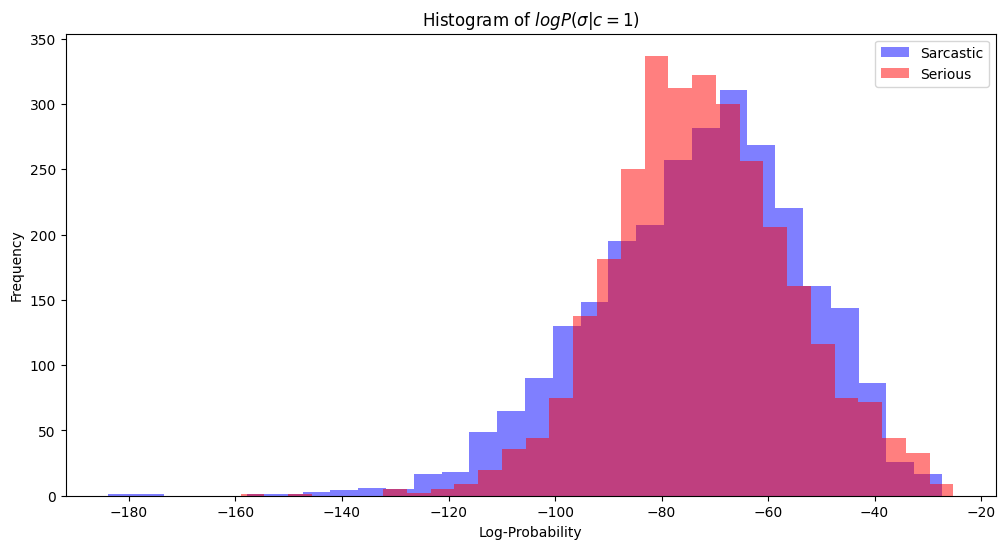

In [13]:
# Separate log-probabilities for sarcastic and non-sarcastic headlines in the test set
log_probs_sarcastic = [dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 1]
log_probs_non_sarcastic = [dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 0]


# Plot histograms of log-probabilities for each class
plt.figure(figsize=(12, 6))
plt.hist(log_probs_sarcastic, bins=30, alpha=0.5, label="Sarcastic", color='blue')
plt.hist(log_probs_non_sarcastic, bins=30, alpha=0.5, label="Serious", color='red')
plt.xlabel("Log-Probability")
plt.ylabel("Frequency")
plt.title(r"Histogram of $logP(\sigma|c=1)$")
plt.legend()
plt.show()


We can see that there is a shift in the peak of the distributions: there's a tendency for the sarcastic headlines to have a higher probability.
However, there's a significant overlap in the log-probability distributions. This suggests that this model doesn’t strongly separate sarcastic from serious headlines. This happens because we are not comparing the probability on the same headline.

<span style="color:red; font-weight:bold">Q2b):</span>

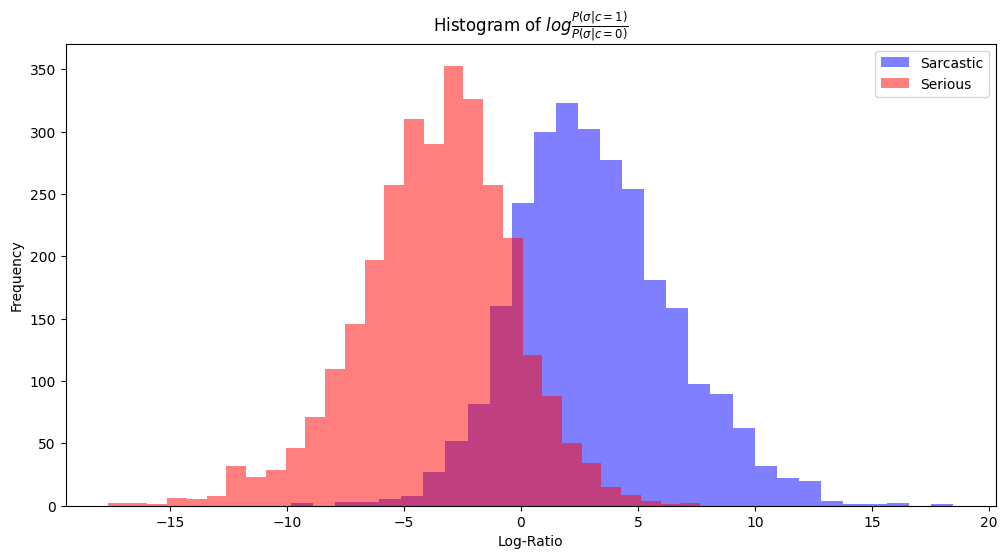

In [14]:
ratio_sarcastic = [dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 1]
ratio_non_sarcastic = [dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 0]

# Plot histograms for both classes
plt.figure(figsize=(12, 6))
plt.hist(ratio_sarcastic, bins=30, alpha=0.5, label="Sarcastic", color='blue')
plt.hist(ratio_non_sarcastic, bins=30, alpha=0.5, label="Serious", color='red')
plt.xlabel("Log-Ratio")
plt.ylabel("Frequency")
plt.title(r"Histogram of $log\frac{P(\sigma|c=1)}{P(\sigma|c=0)}$")
plt.legend()
plt.show()

Now that we are comparing the probability of observing a headline in a given category (sarcastic or non sarcastic) for the same headline:
Sarcastic headlines mostly have positive log-ratios, meaning $P(\sigma|c=1)>P(\sigma|c=0)$ for these headlines i.e. this headlines are more likely to be sarcastic.
Serious headlines mostly have negative log-ratios, meaning $P(\sigma|c=0)>P(\sigma|c=1)$ for these headlines i.e. this headlines are more likely to be serious.


However, there’s still some overlap around a log-ratio close to zero, where both classes have similar probabilities. This overlap indicates that for some headlines, the model isn’t entirely confident and assigns similar probabilities to both classes. And there are even some outliers that are identified in the wrong class.

<span style="color:red; font-weight:bold">Bonus:</span> I didn't really understand the question :(

<span style="color:red; font-weight:bold">Q2c):</span>

In [15]:
# For the case of the histogram computed in a): log P(sigma|c=1)
mean_sarcastic_logP_c1 = np.mean([dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 1])
std_sarcastic_logP_c1 = np.std([dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 1])
mean_serious_logP_c1 = np.mean([dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 0])
std_serious_logP_c1 = np.std([dic['log(P(sigma|c=1))'] for dic in tests_data if dic.get('is_sarcastic') == 0])

# Separation metric for Q2(a)
separation_metric_a = (abs(mean_sarcastic_logP_c1 - mean_serious_logP_c1))/(np.sqrt(std_sarcastic_logP_c1 * std_serious_logP_c1))
print("Separation Metric for Q2(a):", separation_metric_a)

# For Q2(b): log(P(sigma|c=1) / P(sigma|c=0))
mean_sarcastic_log_ratio = np.mean([dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 1])
std_sarcastic_log_ratio = np.std([dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 1])
mean_serious_log_ratio = np.mean([dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 0])
std_serious_log_ratio = np.std([dic['log[(P(sigma|c=1)/(P(sigma|c=0)'] for dic in tests_data if dic.get('is_sarcastic') == 0])

# Separation metric for Q2(b)
separation_metric_b = abs(mean_sarcastic_log_ratio - mean_serious_log_ratio) / np.sqrt(std_sarcastic_log_ratio * std_serious_log_ratio)
print("Separation Metric for Q2(b):", separation_metric_b)

Separation Metric for Q2(a): 0.04209083908979816
Separation Metric for Q2(b): 2.0577830492984375


As concluded before, but now with a quantitative analyses, we can see the difference in separation of the two histograms. We conclude that the approach in Q2b provides much better separation between sarcastic and serious headlines than Q2(a).

## Question 3

**Q3a)** Using Bayes theorem, compute the ratio $P(c=1|\vec{\sigma})/P(c=0|\vec{\sigma})$ for the headlines in your testing set (note that $P(\vec{\sigma})$ cancels). To obtain an empirical estimate of $P(c)$, you can count the number of headlines in each class of the training set. Your classifier will use these ratios as the scores to predict the label of a headline.

**Q3b)** How accurate is this classifier? To quantify this, plot the Receiver Operating Characteristic Curve (ROC) and compute the Area Under the Curve (AUC). See Appendix for an explanation of the ROC and the AUC.

*Hint: The ROC curve is easier to obtain if you assume that the scores are sorted. You can also use the functions `roc_curve` and `auc` from the python package `sklearn`.*

**Bonus:** What is the ROC curve and AUC of a random classifier (that emits random labels for each headline)? What is the ROC curve and AUC of a perfect classifier (that emits the correct label for every headline)?

**Bonus:** Describe the connection between the areas under the histogram  curves of exercise 2 from d) and the AUC.

**(BONUS) Q3c)** Estimate the mutual information between the headline and the label,

$$MI(\vec\sigma,c)=\sum_{\vec\sigma,c}P(\vec\sigma,c)\ln\left(\frac{P(\vec\sigma,c)}{P(\vec\sigma)P(c)}\right)$$

Using the exact expression is intractable. However, you can obtain a practical estimate by approximating the outer average over the model distribution $P(\vec\sigma,c)$, with an empirical average over your data,

$$MI(\vec\sigma,c)\approx\frac{1}{M}\sum_d\ln\left(\frac{P(\vec\sigma_d,c_d)}{P(\vec\sigma_d)P(c_d)}\right)$$

where the sum over $d$ goes over the labeled headlines $\vec\sigma_d,c_d$ of your dataset. Estimate $MI(\vec\sigma,c)$ using this approximate expression for your training set and your testing set.

<span style="color:red; font-weight:bold">Q3a):</span>

$$\frac{P(c=1|\vec{\sigma})}{P(c=0|\vec{\sigma})}=\frac{P(\vec{\sigma}|c=1)P(c=1)}{P(\vec{\sigma}|c=0)P(c=0)}$$

In [16]:
# Empirical probability for a headline to be serious
P_c0 = sum(1 for dic in train_data if dic.get('is_sarcastic') == 0)/len(train_data)
# Empirical probability for a headline to be satirical
P_c1 = sum(1 for dic in train_data if dic.get('is_sarcastic') == 1)/len(train_data)

for dic in tests_data:
    dic['P(c=1|sigma)/P(c=0|sigma)'] = ((dic['P(sigma|c=1)']*P_c1)/(dic['P(sigma|c=0)']*P_c0))
    dic['log(P(c=1|sigma)/P(c=0|sigma))'] = (dic['log(P(sigma|c=1))']+np.log(P_c1)) - (dic['log(P(sigma|c=0))']+np.log(P_c0))

tests_data

[{'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546',
  'log(P(sigma|c=0))': -71.00822174056896,
  'log(P(sigma|c=1))': -66.15015456394505,
  'log[(P(sigma|c=1)/(P(sigma|c=0)': 4.858067176623905,
  'P(sigma|c=0)': 1.4505113395705085e-31,
  'P(sigma|c=1)': 1.8678968763118603e-29,
  'P(c=1|sigma)/P(c=0|sigma)': 117.42995211988779,
  'log(P(c=1|sigma)/P(c=0|sigma))': 4.765842003643684},
 {'is_sarcastic': 1,
  'headline': 'shadow government getting too large to meet in marriott conference room b',
  'article_link': 'https://politics.theonion.com/shadow-government-getting-too-large-to-meet-in-marriott-1819570731',
  'log(P(sigma|c=0))': -84.37977811698069,
  'log(P(sigma|c=1))': -80.77585768867613,
  'log[(P(sigma|c=1)/(P(sigma|c=0)': 3.603920428304562,
  'P(sigma|c=0)': 2.2611427425733238e-37,
  'P(sigma|c=1)': 8.307889945447624e-36,
 

<span style="color:red; font-weight:bold">Q3b):</span>

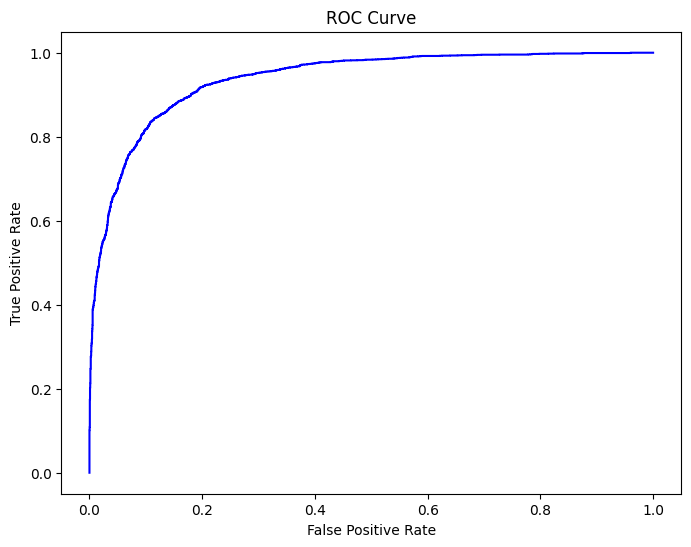

AUC: 0.937272222045405


In [17]:
try:
    # Extract classifier scores and true labels from the test data
    scores = [dic['P(c=1|sigma)/P(c=0|sigma)'] for dic in tests_data]
    true_labels = [dic['is_sarcastic'] for dic in tests_data]

    # compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show() 

    print("AUC:", roc_auc)

except:
    print("I need more train data", "\U0001F62D")

For train data with only 100 headlines, there were some undefined values when trying to compute the ROC, the solution that I found was to do it with log, as I realize that the AUC values, for the same set of train data were the same whether using log or non

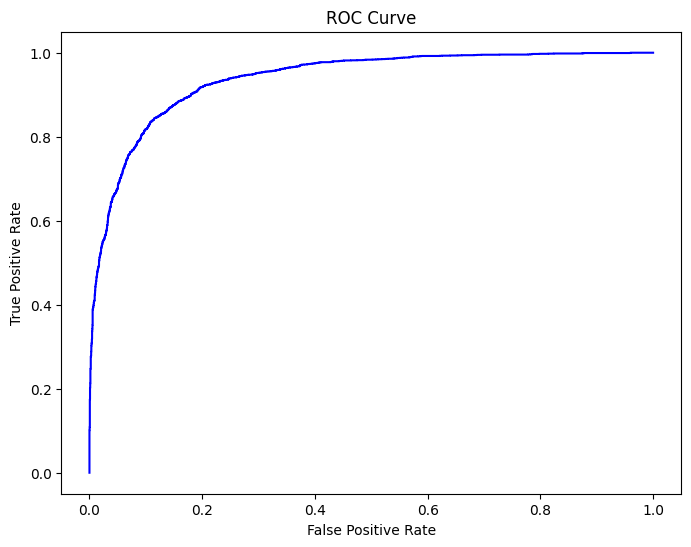

AUC: 0.937272222045405


In [18]:
# Extract classifier scores and true labels from the test data
scores = [dic['log(P(c=1|sigma)/P(c=0|sigma))'] for dic in tests_data]
true_labels = [dic['is_sarcastic'] for dic in tests_data]

# compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("AUC:", roc_auc)


<span style="color:red; font-weight:bold">Bonus:</span>

Random classifier: If our classifier is random, it's not expressing any relation btw the words in the headline and the label. Therefore the number of true positives (TP) and false positives (FP) is expected to be around the same, leading to a linear plot from (0,0) to (1,1). Therefore $AUC = \int_{0}^{1} x \, dx = 0.5$

Perfect classifier: A perfect classifier will classify all sarcastic headlines as sarcastic and serious as serious, so TPR = 1 and FPR = 0. Therefore, $AUC = 1$

The bigger the area of overlapp btw the 2 histograms in Q2b), the more AUC tends to 0.5, the smaller the overlapp the more AUC tends to 1

## Question 4

Compute the Kullback-Leiber (KL) divergences between the 2 models,

$$D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1))$$

and

$$D_{KL}(P(\vec\sigma|c=1) || P(\vec\sigma|c=0))$$

Why are the two KL divergences different?

**Q4a)** Show that the KL divergences above, are sums of contributions for each word. Derive analytical expressions, as functions of the fields $h_i(c)$ in each case.

**Q4b)** Consider the task of classifying a newspaper as publishing sarcastic or non-sarcastic news articles. Estimate (approximatey) how many headlines your model will need to guess the correct classification confidently (with a probability of error below $10^{-10}$), assuming that in reality, i) the news-source publishes sarcastic headlines, or ii) the news-source publishes serious articles.

**Q4c)** To model different newspapers, construct datasets $D_1(c=1), D_2(c=1), \dots, D_{10}(c=1)$ consisting of different numbers of sarcastic headlines only, by taking the first 5, 10, 15, ..., 50, sarcastic headlines from the test dataset. Similarly, construct datasets $D_1(c=0), D_2(c=0), \dots, D_{10}(c=0)$ consisting of serious headlines only, by taking the first 5, 10, 15, .. 50 serious headlines from the test dataset. Compute the log-likelihood of each of these datasets under the two models $P(\vec\sigma|c=0,1)$.

**Q4d)** Plot the log-likelihood difference versus the number of headlines in each of the datasets constructed in c). What is the expected slope of this plot?

**Q4e)** Plot the log-likelihood difference per headlines (i.e., divided by number of headlines), versus the number of headlines in each of the datasets constructed in c). What is the expected asymptotic of this plot?

<span style="color:red; font-weight:bold">Q4a)</span>

The KL divergence measures the difference between two entire probability distributions, so it requires both the probability that the word appears in each class and the probability that the word does not appear in each class:


$$D_{KL}(P(\sigma_i | c=0) || P(\sigma_i | c=1)) = P(\sigma_i = 1 | c=0) ln \frac{P(\sigma_i = 1 | c=0)}{P(\sigma_i = 1 | c=1)} + P(\sigma_i = 0 | c=0) ln \frac{P(\sigma_i = 0 | c=0)}{P(\sigma_i = 0 | c=1)}$$

The likelihood is given by:
$$P(\sigma_i | c) = \frac{e^{h_i(c) \sigma_i}}{1 + e^{h_i(c)}}$$

Let's add the parameter p and q to simplify future calcualtions, and rewrite the likelihood for each case:
$$
P(\sigma_i = 1 | c=0) = p_i = \frac{1}{1 + e^{-h_i(0)}}
$$
$$
P(\sigma_i = 1 | c=1) = q_i = \frac{1}{1 + e^{-h_i(1)}}
$$
$$
P(\sigma_i = 0 | c=0) = 1 - p_i = \frac{e^{-h_i(0)}}{1 + e^{-h_i(0)}}
$$
$$
P(\sigma_i = 0 | c=1) = 1 - q_i = \frac{e^{-h_i(1)}}{1 + e^{-h_i(1)}}
$$

Simplifying we get:

$$
D_{KL}(P(\sigma_i | c=0) || P(\sigma_i | c=1)) = \frac{1}{1 + e^{-h_i(0)}} ln \frac{\frac{1}{1 + e^{-h_i(0)}}}{\frac{1}{1 + e^{-h_i(1)}}} + \frac{e^{-h_i(0)}}{1 + e^{-h_i(0)}} ln \frac{\frac{e^{-h_i(0)}}{1 + e^{-h_i(0)}}}{\frac{e^{-h_i(1)}}{1 + e^{-h_i(1)}}}
$$

$$
D_{KL}(P(\sigma_i | c=0) || P(\sigma_i | c=1)) = h_i(0) - h_i(1) + ln \frac{1 + e^{h_i(1)}}{1 + e^{h_i(0)}}
$$


Summing over all words we find:
$$
D_{KL}(P(\sigma | c=0) || P(\sigma | c=1)) = \sum_i \left( h_i(0) - h_i(1) + ln \frac{1 + e^{h_i(1)}}{1 + e^{h_i(0)}} \right)
$$

Applying the same reason, we get $D_{KL}(P(\sigma | c=1) || P(\sigma | c=0))$:

$$
D_{KL}(P(\sigma | c=1) || P(\sigma | c=0)) = \sum_i \left( h_i(1) - h_i(0) + ln \frac{1 + e^{h_i(0)}}{1 + e^{h_i(1)}} \right)
$$

In [19]:
# P(sigma=1 | c=0)
df['p'] = 1 / (1 + np.exp(-df['field_0'])) 
# P(sigma=1 | c=1)
df['q'] = 1 / (1 + np.exp(-df['field_1'])) 

# Calculate the KL divergence
kl_divergence_0_to_1 = np.sum(df['p'] * np.log(df['p'] / df['q']) + (1 - df['p']) * np.log((1 - df['p']) / (1 - df['q'])))
kl_divergence_1_to_0 = np.sum(df['q'] * np.log(df['q'] / df['p']) + (1 - df['q']) * np.log((1 - df['q']) / (1 - df['p'])))


kl_divergence_0_to_1, kl_divergence_1_to_0

(4.7481402427504795, 4.96483708682758)

KL divergence is not symetric, they represent different directions of information loss:

To simplify the explanation, let's consider a general $D_{KL}(p||q)$. It measures how well distribution q approximates distribution p. $D_{KL}(q||p)$ measures how well distribution p approximates distribution q.

Because $P(\sigma|c=0)$ differ from $P(\sigma|c=1)$ is expected that one divergence is larger than the other.


<span style="color:red; font-weight:bold">Q4b)</span>



The probability of error is related with DKL by:
$$P(|\theta - \theta_{\text{hyp}}| < \epsilon) = e^{-M D_{\text{KL}}(\hat{\theta} \parallel \theta_{\text{hyp}})}$$
Therefore:
$$M = -\frac{ln(Prob(error))}{D_{KL}}$$


<span style="color:red; font-weight:bold">i)</span>

In [20]:
M1 = -np.log(10**-10)/kl_divergence_1_to_0
M1

4.637785797852525

<span style="color:red; font-weight:bold">ii)</span>

In [21]:
M0 = -np.log(10**-10)/kl_divergence_0_to_1
M0

4.849446257426077

Although it's slightly easier to identify a sarcastic news-source, I will need 5 headlines to identify sarcastic and serious news-sources.

<span style="color:red; font-weight:bold">Q4c)</span>

In [22]:
log_likelihoods_sar_c1 = []
log_likelihoods_sar_c0 = []
log_likelihoods_ser_c1 = []
log_likelihoods_ser_c0 = []

subset_sizes = range(5, 51, 5)

for size in subset_sizes:
    # For sarcastic headlines
    subset_sarcastic = [dic for dic in tests_data if dic.get('is_sarcastic') == 1][:size]
    log_likelihood_sar_c1 = sum(dic['log(P(sigma|c=1))'] for dic in subset_sarcastic)
    log_likelihood_sar_c0 = sum(dic['log(P(sigma|c=0))'] for dic in subset_sarcastic)
    log_likelihoods_sar_c1.append(log_likelihood_sar_c1)
    log_likelihoods_sar_c0.append(log_likelihood_sar_c0)
   
    # For serious headlines
    subset_serious = [dic for dic in tests_data if dic.get('is_sarcastic') == 0][:size]
    log_likelihood_ser_c1 = sum(dic['log(P(sigma|c=1))'] for dic in subset_serious)
    log_likelihood_ser_c0 = sum(dic['log(P(sigma|c=0))'] for dic in subset_serious)
    log_likelihoods_ser_c1.append(log_likelihood_ser_c1)
    log_likelihoods_ser_c0.append(log_likelihood_ser_c0)

<span style="color:red; font-weight:bold">Q4d)</span>

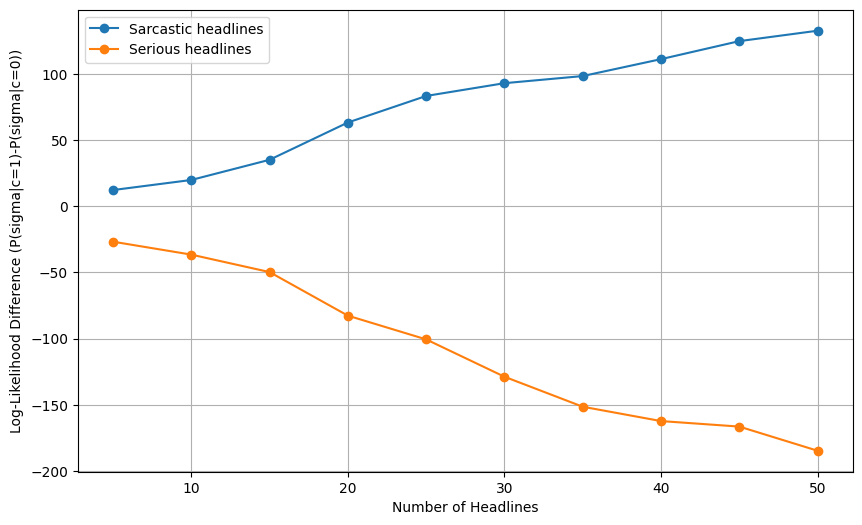

In [23]:
# Define subset sizes
subset_sizes = range(5, 51, 5)

# Calculate log-likelihood differences 
log_likelihood_diff_sarcastic = [
    a - b for a, b in zip(log_likelihoods_sar_c1, log_likelihoods_sar_c0)
]
log_likelihood_diff_serious = [
    a - b for a, b in zip(log_likelihoods_ser_c1, log_likelihoods_ser_c0)
]

# Plot log-likelihood differences 
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, log_likelihood_diff_sarcastic, label="Sarcastic headlines", marker='o')
plt.plot(subset_sizes, log_likelihood_diff_serious, label="Serious headlines", marker='o')
plt.xlabel("Number of Headlines")
plt.ylabel("Log-Likelihood Difference (P(sigma|c=1)-P(sigma|c=0))")
plt.legend()
plt.grid(True)
plt.show()


The difference btw $P(\sigma|c=1)$ and $P(\sigma|c=0)$ for the sarcastic subset grows as the number of headlines in the subset grows, this means that the model is getting better at predicting the sarcastic headlines. 
The difference btw $P(\sigma|c=1)$ and $P(\sigma|c=0)$ for the serious subset is getting more negative as the number of headlines in the subset grows, this also means that the model is getting better in predicting the sarcastic headlines. 

I expect the slopes to be similar to a logarithmic function. Of course, for the serious headlines the slop should be $\propto$ -log.

<span style="color:red; font-weight:bold">Q4e)</span>

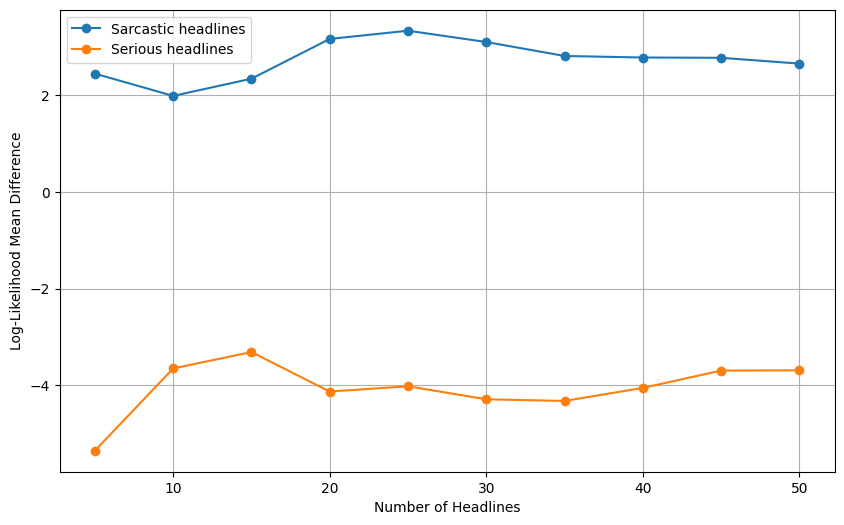

In [24]:
# Calculate log-likelihood differences per headline
log_likelihood_diff_sarcastic = [
    (a-b)/size for a, b, size in zip(log_likelihoods_sar_c1, log_likelihoods_sar_c0,subset_sizes)
]
log_likelihood_diff_serious = [
    (a-b)/size for a, b, size in zip(log_likelihoods_ser_c1, log_likelihoods_ser_c0,subset_sizes)
]
 
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, log_likelihood_diff_sarcastic, label="Sarcastic headlines", marker='o')
plt.plot(subset_sizes, log_likelihood_diff_serious, label="Serious headlines", marker='o')
plt.xlabel("Number of Headlines")
plt.ylabel("Log-Likelihood Mean Difference")
plt.legend()
plt.grid(True)
plt.show()


I expect both curves to reach a point in which adding headlines doesn't lead to a significant change in the difference of the mean values, reaching a steady-state.

## Question 5

In the previous exercises, your training dataset contained $\approx 80\%$ of headlines in your entire dataset. Repeat exericses 1-4, but reducing your training dataset to only the first 100, 1000, and 10000 headlines, assigning all the remaining headlines to the testing set. Discuss the impact on the performance of the model of the limited training data. Plot the AUC for the different sizes of training data, and the score computed in Q2c. *Hint: You can just modify the definition of `train_data` in the first cell of this notebook and re-run everything else!*

<span style="color:red; font-weight:bold">Q5)</span>

For an easy interpretation and correction I uploaded the ROC plots computed with this script for smaller training datasets. To verify them, it's only necessary to change the script in the first cell.

For data_train with 100 headlines:

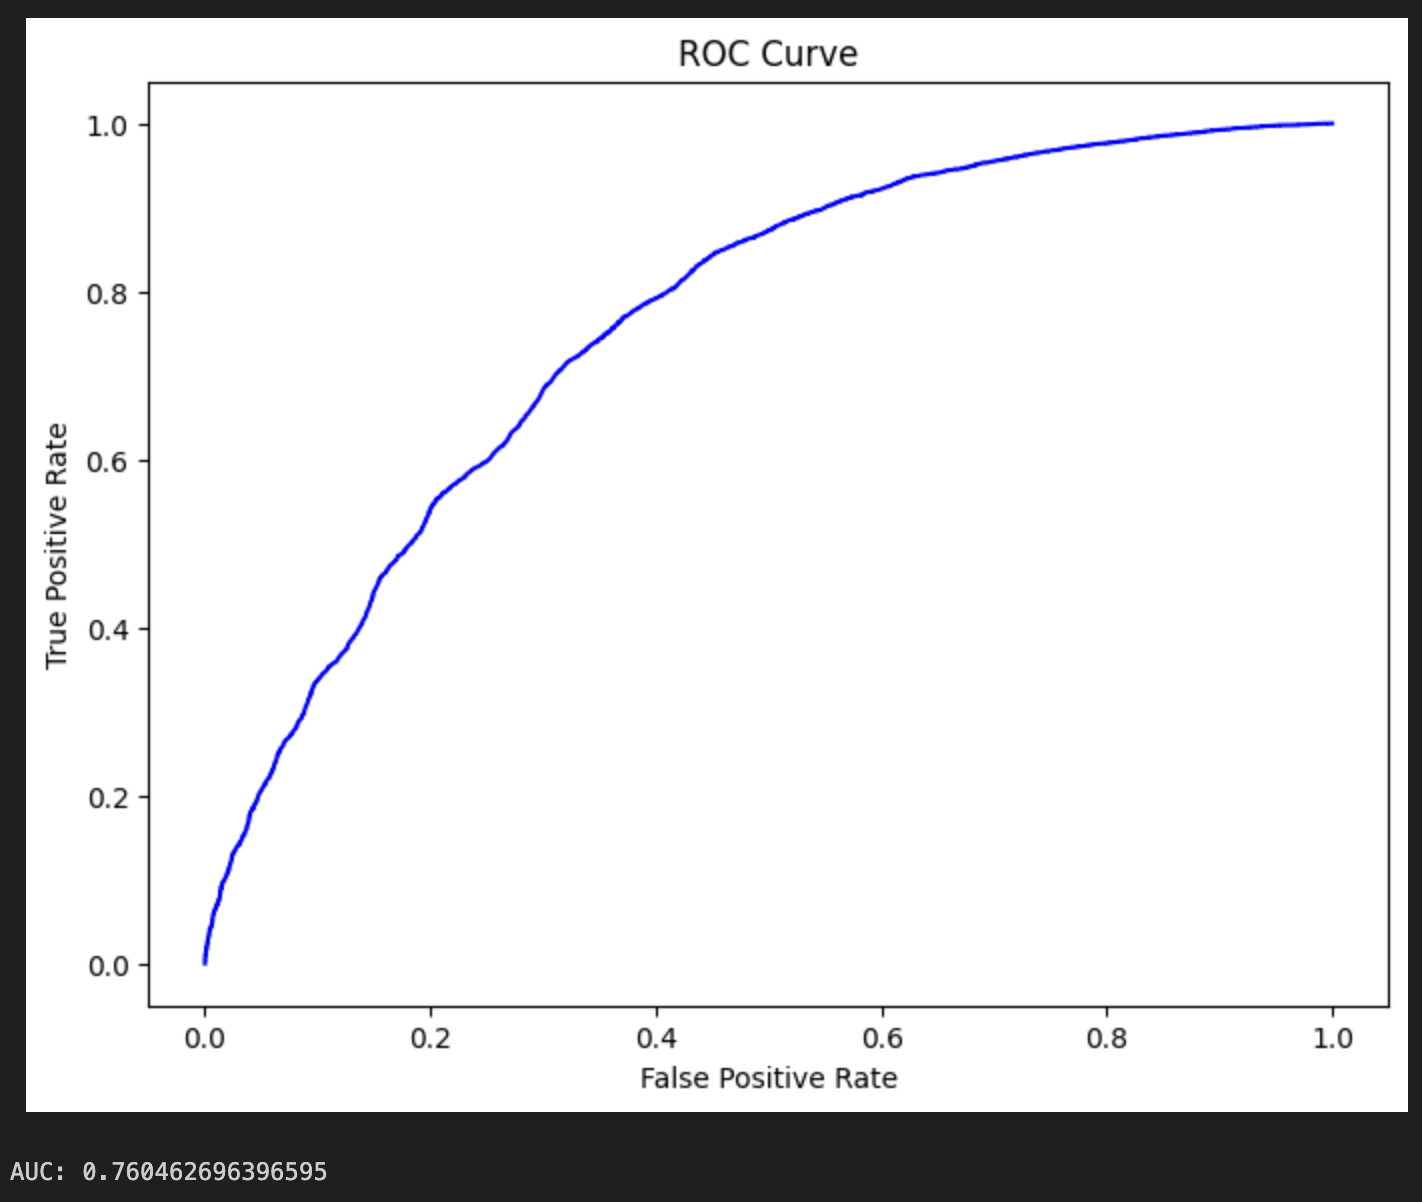

In [25]:
display(Image(filename="data/100.png",width=700, height=200))

For data_train with 1000 headlines:

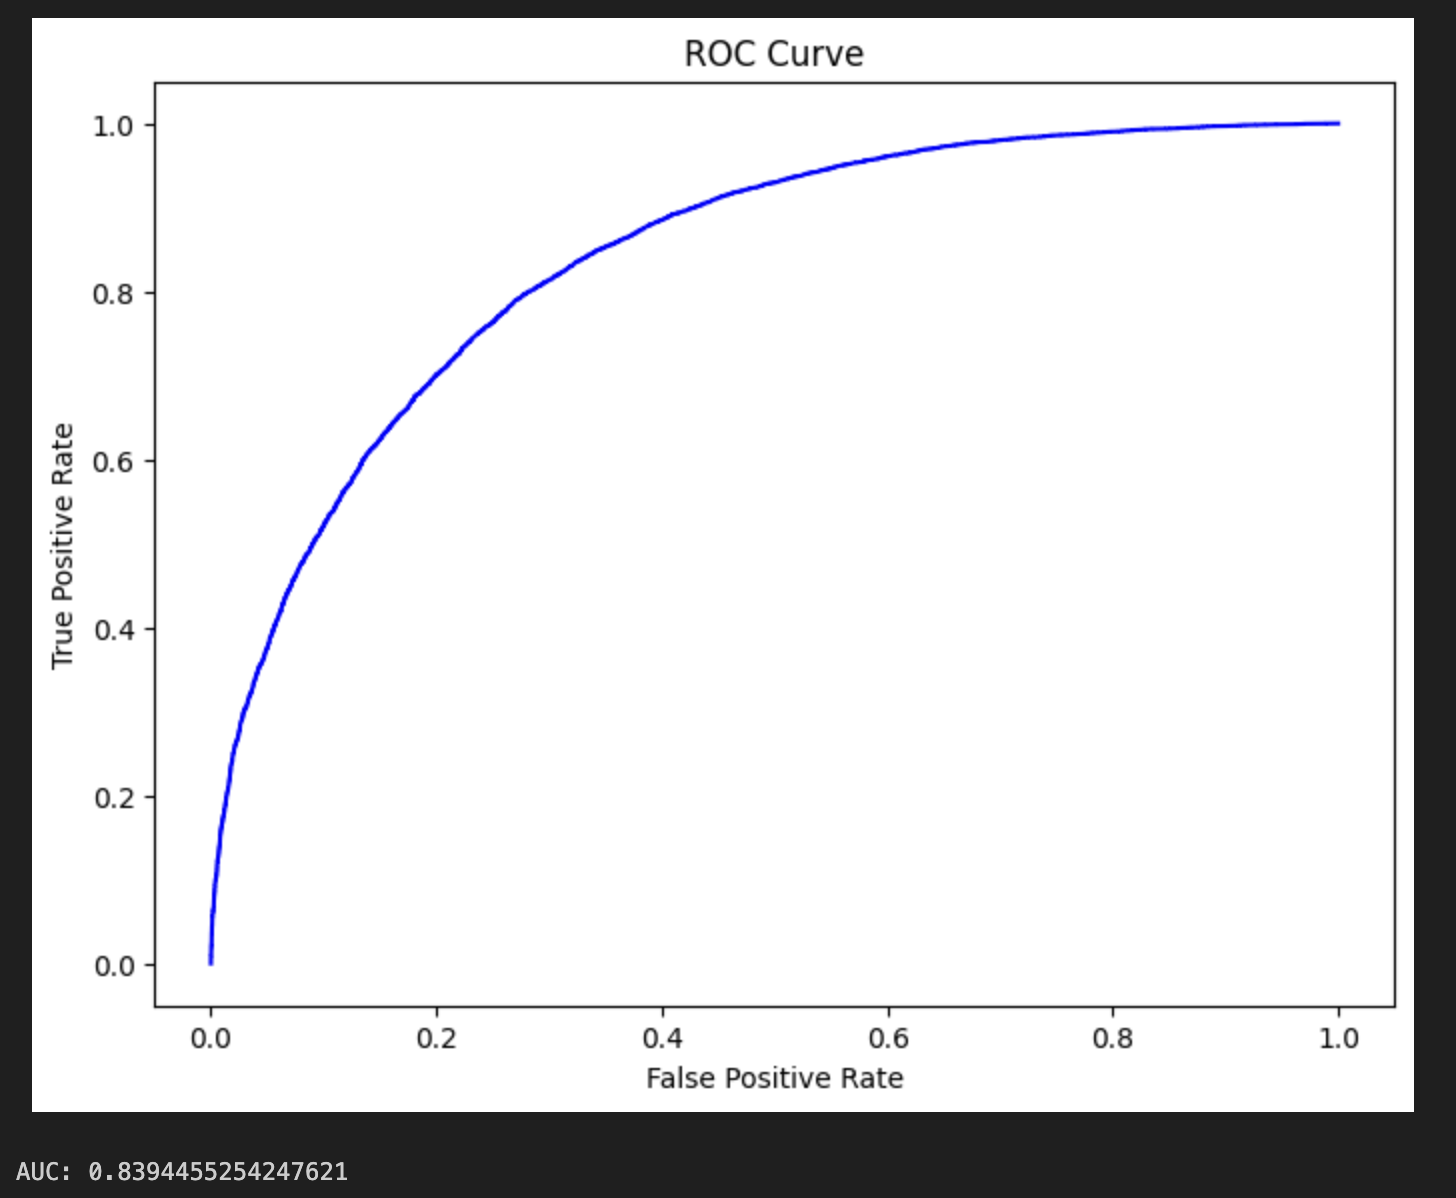

In [26]:
display(Image(filename="data/1000.png",width=700, height=200))

For data_train with 10000 headlines:

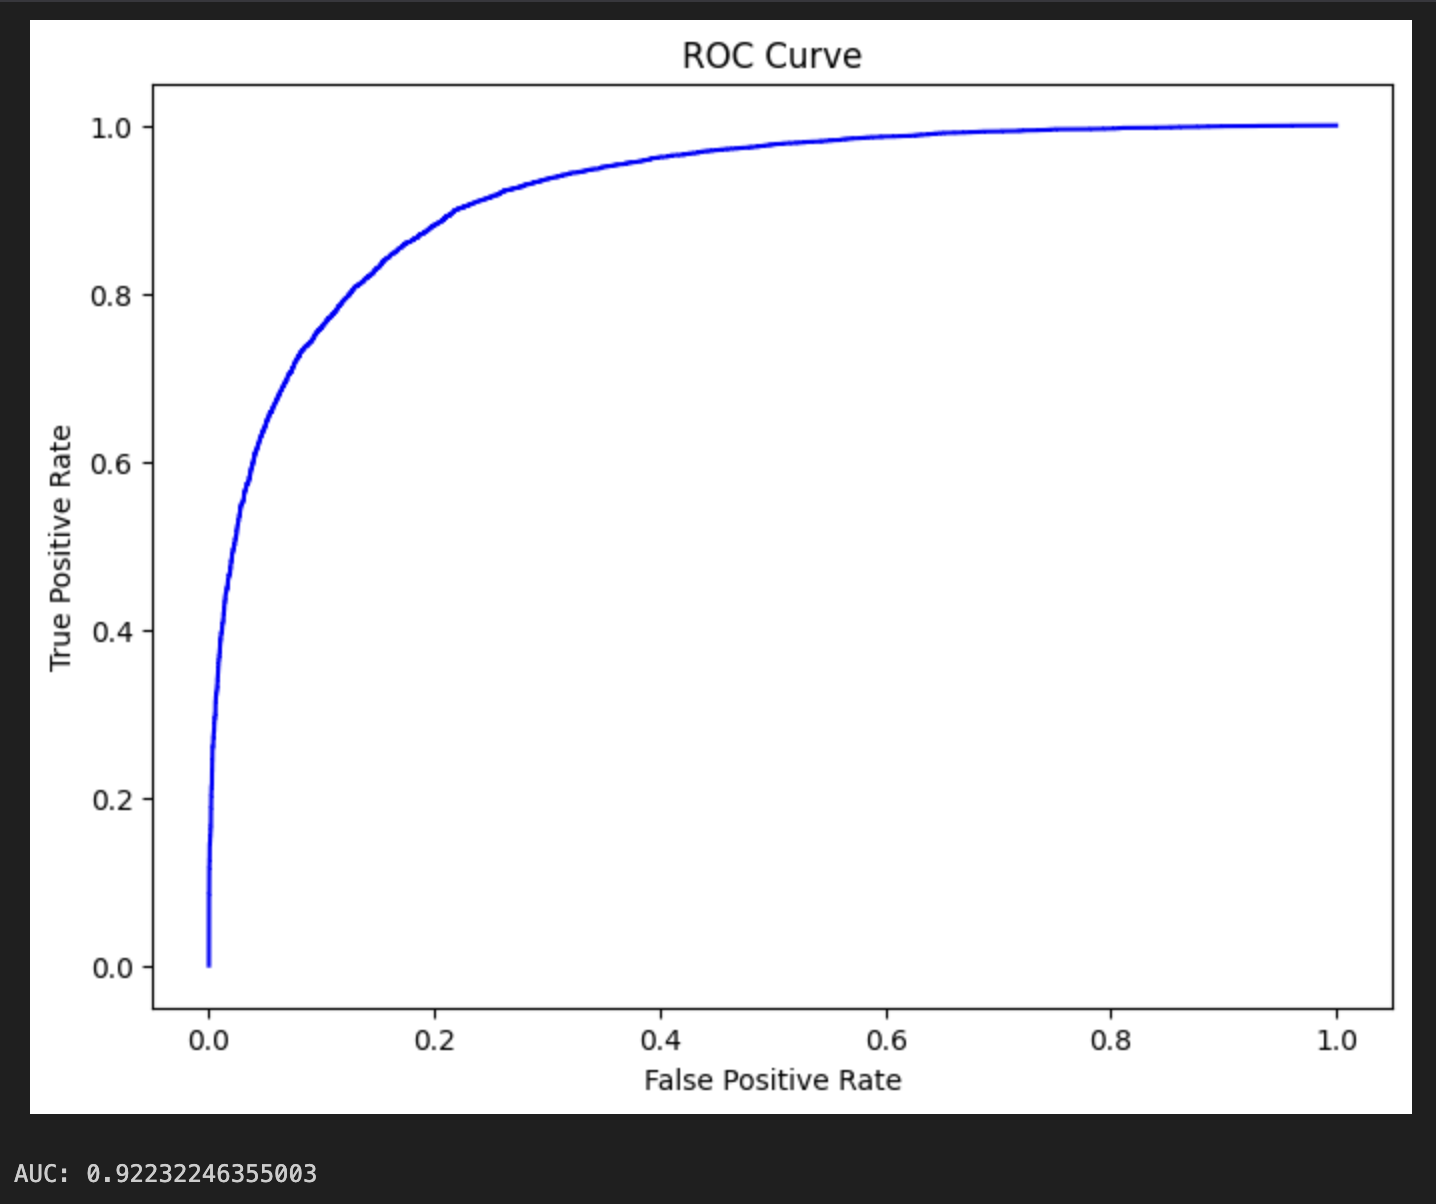

In [27]:
display(Image(filename="data/10000.png", width=700, height=200))

The AUC values for 100, 1000, 10000 and 22896 headlines of training data are respectively, 0.76, 0.84, 0.92 and 0.94. This trend shows an improvement in model performance: as we add more training data, further we move away from a random classifier (AUC = 0.5). 

The lower rate of increase at bigger training datasets may suggest that the model is approaching a saturation point. 

With smaller training sets, the model doesn’t have enough examples to learn the patterns effectively, leading to underfitting. For examplo for 100 headlines of training data it's sligtly better than a random classifier. 


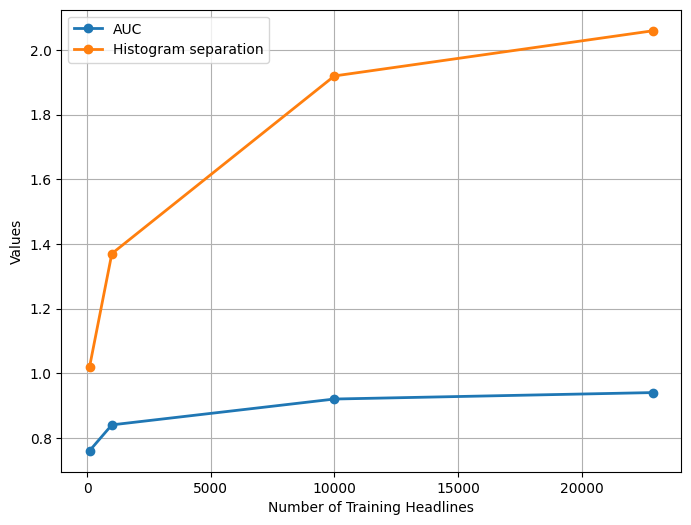

In [32]:
training_data_sizes = [100, 1000, 10000, 22896]
auc = [0.76, 0.84, 0.92, 0.94]
separation = [1.02, 1.37, 1.92, 2.06]

plt.figure(figsize=(8, 6))
plt.plot(training_data_sizes, auc, marker='o', linestyle='-', linewidth=2, label="AUC")
plt.plot(training_data_sizes, separation, marker='o', linestyle='-', linewidth=2, label="Histogram separation")
plt.xlabel("Number of Training Headlines")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
plt.show()

# Appendix: ROC and AUC

Giving predicted scores $S_i$ (in the exercises above you will use the odds ratio $P(c=1|\vec\sigma)/P(c=0|\vec\sigma)$ of the headlines $\vec\sigma_i$, and their true labels, $y_i=0,1$, we consider a threshold $t$ and assume that headlines for which $S_i > t$ are predicted to be sarcastic, while those for which $S_i\le t$ are predicted to be non-sarcastic. We define:

$$TP(t) = \text{number of true positives}\quad
(S_i > t\, \text{and}\, y_i=1)$$
$$FP(t) = \text{number of false positives}\quad
(S_i > t\, \text{and}\, y_i=0)$$

That is, $TP(t)$ is the number of correctly classified positive (sarcastic) headlines, and $FP(t)$ is the number of wrongly classified negative (non-sarcastic) headlines. In addition, let $P$ be the total number of sarcastic headlines in the data, and $N$ the total number of non-sarcastic headlines. Finally we define:

$$TPR(t) = \frac{TP(t)}{P} ,\qquad FPR(t) = \frac{FP(t)}{N}$$

The ROC curve is defined as the parametric curve $(FPR(t), TPR(t))$, traversed as the threshold takes all possible values, $-\infty<t<\infty$. Notice that $0\le TPR(t)\le1$ and $0\le FPR(t)\le1$, and that:

$$TPR(-\infty)=FPR(-\infty)=1,\qquad TPR(\infty)=FPR(\infty)=0$$

The AUC is defined as the area under this curve:

$$AUC = \int_{t=-\infty}^\infty TPR(t) \times \mathrm d FPR(t)
= \int_{t=-\infty}^\infty TPR(t) \times \frac{\mathrm d FPR(t)}{\mathrm d t} \mathrm{d}t$$